# PyTorch Threads

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import optim
import torch.nn.functional as F

from transformers import BertForSequenceClassification, BertConfig, BertTokenizer

from pathlib import Path
import time
import timeit
import onnxruntime as ort
from onnxruntime import InferenceSession
from optimum.onnxruntime import ORTModelForSequenceClassification

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(f"Initial threads: {torch.get_num_threads()}")

Initial threads: 4


In [3]:
i2w = {0: 'positive', 1: 'neutral', 2: 'negative'}

path = "./../model/indobert-onnx/"
onnx_path = path + "/quantized_optimized.onnx"
tokenizer = BertTokenizer.from_pretrained(path)
sess = InferenceSession(onnx_path, providers=["CPUExecutionProvider"])

In [4]:
def evaluate_onnx(session):
  i2w = {0: 'positive', 1: 'neutral', 2: 'negative'}

  # Load data test
  test_dataset_path = "./../dataset/test_preprocess.tsv"
  df_test = pd.read_table(test_dataset_path, header=None)
  df_test.rename(columns={0: "text", 1: "label"}, inplace=True)

  def infer(text):
    inputs = tokenizer([text])
    inputs_onnx = dict(
        input_ids=np.array(inputs["input_ids"]).astype("int64"),
        attention_mask=np.array(inputs["attention_mask"]).astype("int64"),
        token_type_ids=np.array(inputs["token_type_ids"]).astype("int64")
    )

    logits = session.run(None, input_feed=inputs_onnx)[0]
    label = torch.topk(torch.from_numpy(logits), k=1, dim=-1)[1].squeeze().item()
    probability = F.softmax(torch.from_numpy(logits), dim=-1).squeeze()[label].item()
    return i2w[label]

  df_test['pred'] = df_test['text'].apply(infer)
  acc = accuracy_score(df_test['label'], df_test['pred'])
  pre = precision_score(df_test['label'], df_test['pred'], average="macro")
  rec = recall_score(df_test['label'], df_test['pred'], average="macro")
  f1 = f1_score(df_test['label'], df_test['pred'], average="macro")

  return {"accuracy": acc,
          "precision": pre,
          "recall": rec,
          "f1": f1}

def eval_time_onnx(model):
  start = time.time()
  result = evaluate_onnx(model)
  print(f"""
  Accuracy:{result['accuracy']}
  Precision:{result['precision']}
  Recall: {result['recall']}
  F1-Score: {result['f1']}
  """)
  end = time.time()
  print(f"Evaluation time: {end-start}")

In [5]:
performances = {}

for i in range(1, 9):
    torch.set_num_threads(i)
    print(f"Threads: {torch.get_num_threads()}")
    start = time.time()
    eval_time_onnx(sess)
    end = time.time()
    duration = end-start
    print(f"Duration: {duration}\n")
    performances[i] = duration

Threads: 1

  Accuracy:0.91
  Precision:0.904624861247909
  Recall: 0.8688182732300381
  F1-Score: 0.8821104124344225
  
Evaluation time: 5.838076591491699
Duration: 5.838076591491699

Threads: 2

  Accuracy:0.91
  Precision:0.904624861247909
  Recall: 0.8688182732300381
  F1-Score: 0.8821104124344225
  
Evaluation time: 5.852615833282471
Duration: 5.852615833282471

Threads: 3

  Accuracy:0.91
  Precision:0.904624861247909
  Recall: 0.8688182732300381
  F1-Score: 0.8821104124344225
  
Evaluation time: 5.824410915374756
Duration: 5.824410915374756

Threads: 4

  Accuracy:0.91
  Precision:0.904624861247909
  Recall: 0.8688182732300381
  F1-Score: 0.8821104124344225
  
Evaluation time: 6.86527419090271
Duration: 6.86527419090271

Threads: 5

  Accuracy:0.91
  Precision:0.904624861247909
  Recall: 0.8688182732300381
  F1-Score: 0.8821104124344225
  
Evaluation time: 9.328073024749756
Duration: 9.328073024749756

Threads: 6

  Accuracy:0.91
  Precision:0.904624861247909
  Recall: 0.8688182

In [6]:
def benchmark(f, name=""):
    # warmup
    for _ in range(10):
        f()
    seconds_per_iter = timeit.timeit(f, number=100) / 100
    print(
        f"{name}:",
        f"{seconds_per_iter * 1000:.3f} ms",
    )

    return seconds_per_iter * 1000

In [7]:
text = 'Bahagia hatiku melihat pernikahan putri sulungku yang cantik jelita'

inputs_onnx = tokenizer([text])
inputs_onnx = dict(
    input_ids=np.array(inputs_onnx["input_ids"]).astype("int64"),
    attention_mask=np.array(inputs_onnx["attention_mask"]).astype("int64"),
    token_type_ids=np.array(inputs_onnx["token_type_ids"]).astype("int64")
)

model_onnx = InferenceSession(onnx_path, providers=["CPUExecutionProvider"])

In [8]:
performances_2 = {}

for i in range(1, 9):
    torch.set_num_threads(i)
    print(f"Threads: {torch.get_num_threads()}")
    start = time.time()
    benchmark(lambda: model_onnx.run(None, input_feed=inputs_onnx), f"ONNX {i}")
    end = time.time()
    duration = end-start
    print(f"Duration: {duration}\n")
    performances_2[i] = duration

Threads: 1
ONNX 1: 7.705 ms
Duration: 0.8547115325927734

Threads: 2
ONNX 2: 7.232 ms
Duration: 0.7999415397644043

Threads: 3
ONNX 3: 7.452 ms
Duration: 0.8150112628936768

Threads: 4
ONNX 4: 7.583 ms
Duration: 0.8468034267425537

Threads: 5
ONNX 5: 7.371 ms
Duration: 0.8058979511260986

Threads: 6
ONNX 6: 7.324 ms
Duration: 0.8377392292022705

Threads: 7
ONNX 7: 7.167 ms
Duration: 0.8235318660736084

Threads: 8
ONNX 8: 7.237 ms
Duration: 0.7973592281341553



Text(0.5, 1.0, 'PyTorch Threads Experiment 1')

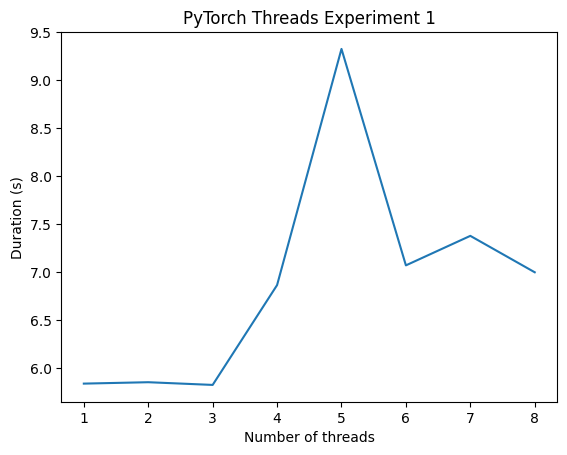

In [9]:
x = np.array(range(1, 9))
y = np.array([item for item in performances.values()])
plt.plot(x, y)
plt.xlabel("Number of threads")
plt.ylabel("Duration (s)")
plt.title("PyTorch Threads Experiment 1")

Text(0.5, 1.0, 'PyTorch Threads Experiment 2')

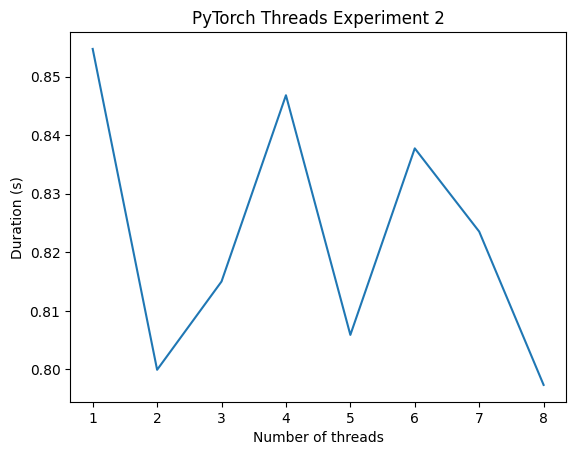

In [10]:
x = np.array(range(1, 9))
y = np.array([item for item in performances_2.values()])
plt.plot(x, y)
plt.xlabel("Number of threads")
plt.ylabel("Duration (s)")
plt.title("PyTorch Threads Experiment 2")

We experimented with varying threads available to the single process in a single instance. We try two methods to measure the performance. First method is measuring how much time taken to inference through all the test data. The second method is to inference a single text a hundred times and find its mean time.

The best results were achieved with two threads (torch.set_num_threads(2)) in both ways. Theoretically, increasing the number of threads should make the inference faster. So, I can say that this method doesn't work as it should be.